In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 28.4 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [5]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
d3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l3.csv')

d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
d3_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l3.csv')


In [6]:
# Verify GPU availability
if not torch.cuda.is_available():
    raise RuntimeError("GPU not available. Please enable GPU in your environment (e.g., Colab Runtime -> Change runtime type -> GPU).")
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: Tesla T4


In [7]:

def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

d3['text'] = d3['text'].apply(lambda x: normalize_text(x))
d3_test['text'] = d3_test['text'].apply(lambda x: normalize_text(x))

In [8]:
d1.head()
d3.head()

,text,key,ta_a1,ta_a2,ta_a3,ta_a4,ta_a5,ta_a6
0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,question_3,NaN,NaN,0.0,0.0,0.0,0.0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,question_3,NaN,NaN,NaN,1.0,NaN,NaN
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,question_3,NaN,NaN,NaN,NaN,0.0,NaN
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...,question_3,NaN,NaN,NaN,NaN,1.0,NaN
4,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...,question_3,1.0,NaN,NaN,NaN,NaN,NaN


In [9]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])
X3 = list(d3['text'])
X3_test = list(d3_test['text'])

col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')

    d3[col] = pd.to_numeric(d3[col], errors='coerce')
    d3_test[col] = pd.to_numeric(d3_test[col], errors='coerce')


d1['label_1'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label_1'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3['label_3'] = d3[col_lst].max(axis=1, skipna=True).astype(int)
d3_test['label_3'] = d3_test[col_lst].max(axis=1, skipna=True).astype(int)


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)
d3 = d3.drop(col_lst, axis=1)
d3_test = d3_test.drop(col_lst, axis=1)

d1['label_1'] = d1['label_1'].astype(int)
d1_test['label_1'] = d1_test['label_1'].astype(int)
d3['label_3'] = d3['label_3'].astype(int)
d3_test['label_3'] = d3_test['label_3'].astype(int)


d1 = d1[['label_1', 'text']]
d1_test = d1_test[['label_1', 'text']]
d1_test

d3 = d3[['label_3', 'text']]
d3_test = d3_test[['label_3', 'text']]
d3_test

,label_3,text
0,0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...
1,1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...
2,1,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...
3,0,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...
4,1,bachelor :face_with_steam_from_nose::face_wit...
...,...,...
1130,1,:face_with_tears_of_joy::face_with_tears_of_jo...
1131,1,:grinning_face_with_smiling_eyes: தமிழ் தெரிஞ்...
1132,1,:grinning_face_with_sweat::grinning_face_with_...
1133,1,:grinning_cat::pencil: — ஆமாம் வேச ஆமாம் வேச அ...


In [10]:
dn = pd.concat([d1, d3.drop(columns=['text'])], axis=1)
dn_test = pd.concat([d1_test, d3_test.drop(columns=['text'])], axis=1)

dn = dn[['text', 'label_1', 'label_3']]
dn_test = dn_test[['text', 'label_1', 'label_3']]
dn_test

,text,label_1,label_3
0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...,0,0
1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...,1,1
2,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...,0,1
3,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...,0,0
4,bachelor :face_with_steam_from_nose::face_wit...,1,1
...,...,...,...
1130,:face_with_tears_of_joy::face_with_tears_of_jo...,1,1
1131,:grinning_face_with_smiling_eyes: தமிழ் தெரிஞ்...,1,1
1132,:grinning_face_with_sweat::grinning_face_with_...,1,1
1133,:grinning_cat::pencil: — ஆமாம் வேச ஆமாம் வேச அ...,1,1


In [11]:
# Create new label column based on logic
def assign_label(row):
    label_1 = row['label_1']
    label_3 = row['label_3']

    # Handle NaN cases (rows with only label_1 or label_3)
    if pd.isna(label_1) and pd.isna(label_3):
        return np.nan  # Both missing
    elif pd.isna(label_1):
        # Only label_3 exists (from d3, d3_test)
        return 1 if label_3 == 1 else 0  # Treat as binary
    elif pd.isna(label_3):
        # Only label_1 exists (from d1, d1_test)
        return 2 if label_1 == 1 else 0  # Treat as binary
    else:
        # Both labels exist (unlikely unless datasets overlap)
        if label_1 == 0 and label_3 == 0:
            return 0
        elif label_1 == 0 and label_3 == 1:
            return 1
        elif label_1 == 1 and label_3 == 0:
            return 2
        else:  # label_1 == 1 and label_3 == 1
            return 3

# dn_new=dn.copy()
dn['label'] = dn.apply(assign_label, axis=1)

# dn_test_new=dn_test.copy()
dn_test['label'] = dn_test.apply(assign_label, axis=1)

dn

,text,label_1,label_3,label
0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,0,0,0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,0,1,1
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,0,0,0
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...,1,1,3
4,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...,1,1,3
...,...,...,...,...
6774,:loudly_crying_face::loudly_crying_face::loudl...,1,1,3
6775,:face_with_rolling_eyes::face_with_rolling_eye...,0,0,0
6776,:police_car_light:எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ...,0,0,0
6777,:rolling_on_the_floor_laughing: :rolling_on_th...,0,1,1


In [12]:
dn = dn[['label', 'text']].copy()
dn_test = dn_test[['label', 'text']].copy()
dn

print(dn['label'].value_counts())
print(dn_test['label'].value_counts())

label
3    2977
0    2324
1    1453
2      25
Name: count, dtype: int64
label
3    715
0    275
1    139
2      6
Name: count, dtype: int64


In [13]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [14]:

from datasets import Dataset

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dn, test_size=0.25, random_state=42, shuffle=True)

X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = val_df['text'], val_df['label']

X_test, y_test = dn_test['text'], dn_test['label']




In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    accuracy = accuracy_score(labels, preds)
    mf1Score = f1_score(labels, preds, average='macro')
    f1Score  = f1_score(labels, preds, average='weighted')
    recallScore = recall_score(labels, preds, average='weighted')
    precisionScore = precision_score(labels, preds, average='weighted')

    try:
        auc = roc_auc_score(labels, logits, multi_class='ovr')  # for multi-class
    except:
        auc = None

    return {
        "accuracy": accuracy,
        "mF1Score": mf1Score,
        "f1Score": f1Score,
        # "auc": auc,
        "precision": precisionScore,
        "recall": recallScore
    }


In [16]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=4).to('cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Initialize tokenizer
# Freeze lower layers (first 8 of 12) to speed up
for name, param in model.named_parameters():
    if 'bert.encoder.layer' in name and int(name.split('.')[3]) < 8:
        param.requires_grad = False

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Convert to datasets.Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].rename(columns={'label': 'labels'}))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].rename(columns={'label': 'labels'}))
test_dataset = Dataset.from_pandas(dn_test[['text', 'label']].rename(columns={'label': 'labels'}))

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns and set format
train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.remove_columns(['text'])
test_dataset = test_dataset.remove_columns(['text'])

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/5084 [00:00<?, ? examples/s]

Map:   0%|          | 0/1695 [00:00<?, ? examples/s]

Map:   0%|          | 0/1135 [00:00<?, ? examples/s]

In [18]:
from transformers import Trainer, TrainingArguments

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    eval_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch',
    save_steps=50,
    logging_dir='./logs',
    logging_strategy='epoch',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model='eval_loss',
    learning_rate=2e-7,
    weight_decay=0.01,
    report_to='none',
    fp16=True,
    dataloader_num_workers=4
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Mf1score,F1score,Precision,Recall
1,1.402800,1.372941,0.368732,0.193335,0.312742,0.350409,0.368732
2,1.357900,1.331398,0.382891,0.168266,0.277491,0.346653,0.382891
3,1.321300,1.301783,0.398230,0.161456,0.266321,0.357770,0.398230
4,1.298800,1.282281,0.421829,0.157101,0.265723,0.362045,0.421829
5,1.282300,1.270298,0.426549,0.155472,0.263562,0.362020,0.426549
6,1.274500,1.266460,0.427729,0.155713,0.263970,0.374199,0.427729


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

TrainOutput(global_step=954, training_loss=1.322933316980518, metrics={'train_runtime': 824.039, 'train_samples_per_second': 37.018, 'train_steps_per_second': 1.158, 'total_flos': 8026083756048384.0, 'train_loss': 1.322933316980518, 'epoch': 6.0})

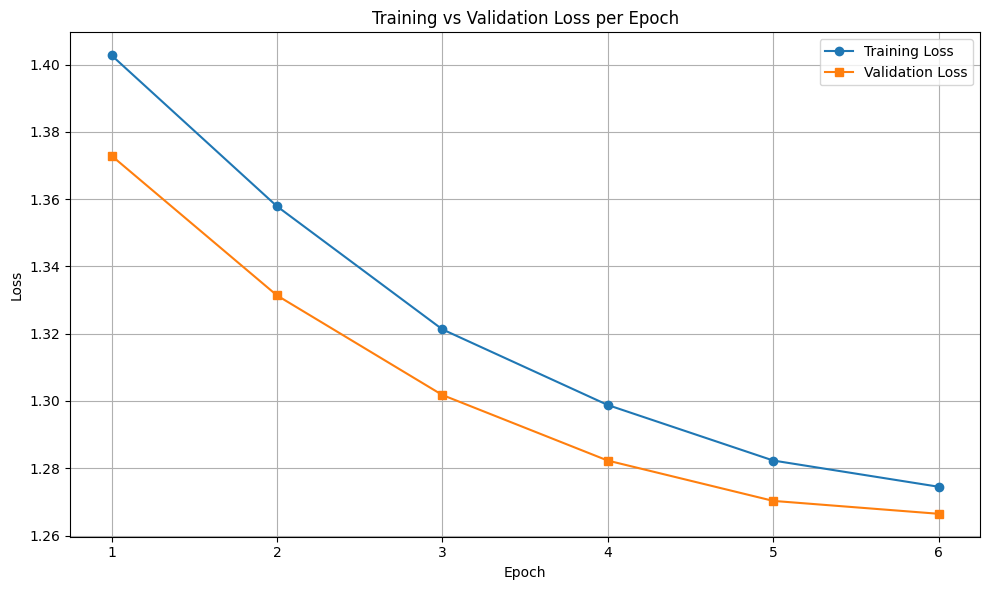

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_epochs, train_losses = [], []
val_epochs, val_losses = [], []

for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log and 'eval_loss' not in log:
        train_epochs.append(log['epoch'])
        train_losses.append(log['loss'])
    elif 'eval_loss' in log and 'epoch' in log:
        val_epochs.append(log['epoch'])
        val_losses.append(log['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label='Training Loss', marker='o')
plt.plot(val_epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Classification Report:
              precision    recall  f1-score   support

     Neutral       0.75      0.03      0.06       275
     Hate_d3       0.00      0.00      0.00       139
     Hate_d1       0.00      0.00      0.00         6
        Both       0.63      1.00      0.77       715

    accuracy                           0.64      1135
   macro avg       0.35      0.26      0.21      1135
weighted avg       0.58      0.64      0.50      1135


Test Average Metrics:
Average Precision: 0.35
Average Recall: 0.26
Average F1-Score: 0.21
Macro AUC: 0.60


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


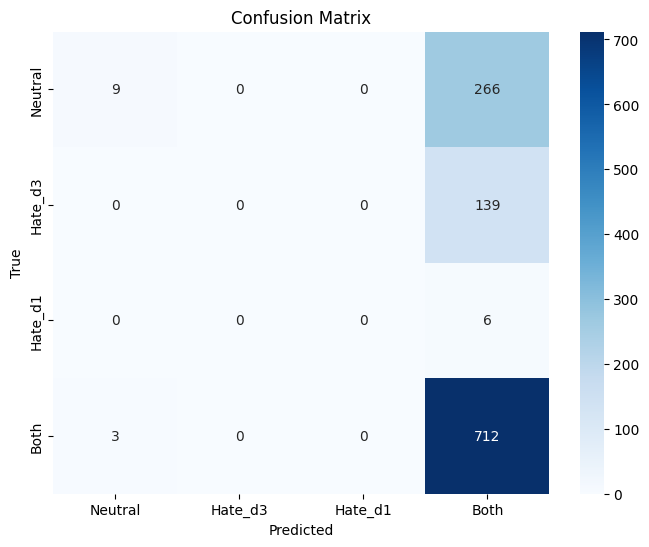


Test Label Distribution:
0    275
1    139
2      6
3    715
Name: count, dtype: int64


In [22]:
# Evaluate on test set
from scipy.special import softmax
test_results = trainer.predict(test_dataset)
test_logits = test_results.predictions
test_predictions = np.argmax(test_logits, axis=-1)
test_probabilities = softmax(test_logits, axis=-1)
test_labels = test_results.label_ids

# Metrics
print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=["Neutral", "Hate_d3", "Hate_d1", "Both"], digits=2))

avg_precision = precision_score(test_labels, test_predictions, average="macro", zero_division=0)
avg_recall = recall_score(test_labels, test_predictions, average="macro", zero_division=0)
avg_f1 = f1_score(test_labels, test_predictions, average="macro", zero_division=0)

print(f"\nTest Average Metrics:")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-Score: {avg_f1:.2f}")

# AUC (multiclass, one-vs-rest)
auc_scores = []
for i in range(4):
    auc = roc_auc_score(test_labels == i, test_probabilities[:, i])
    auc_scores.append(auc)
macro_auc = np.mean(auc_scores)
print(f"Macro AUC: {macro_auc:.2f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neutral", "Hate_d3", "Hate_d1", "Both"], yticklabels=["Neutral", "Hate_d3", "Hate_d1", "Both"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Label distribution
print("\nTest Label Distribution:")
print(pd.Series(test_labels).value_counts().sort_index())